In [1]:
import pandas as pd
import os
%pylab inline
import json
from pandas.io.json import json_normalize
import altair as alt
#alt.renderers.enable('notebook', embed_options={'actions': True})

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tqdm import tqdm_notebook as tqdm

In [3]:
json_results = []
folder="../cal_new_training/"
for f in tqdm(os.listdir(folder)):
    json_results.append(json.load(open(folder+"/"+f)))

folder="../dt_2021_cal_results/json_files/"
for f in tqdm(os.listdir(folder)):
    json_results.append(json.load(open(folder+"/"+f)))

<ipython-input-3-19147009b92b>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm(os.listdir(folder)):


<ipython-input-3-19147009b92b>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for f in tqdm(os.listdir(folder)):


In [4]:
df = pd.DataFrame(json_results)
df.columns=["horizon","method",2,3]
df["horizon"]=df["horizon"].astype(int)
df["pred"]=df.apply(lambda row:row[2]["all"], axis=1)
df["target"]=df.apply(lambda row:row[2]["target"], axis=1)

In [5]:
def reliability_sharpness(pred, target):
    df = pd.DataFrame(pred)
    quantiles = np.arange(1,100)/100.0 
    df.columns = quantiles.astype(str)
    quantiles = np.arange(1,10)/10.0
    df["true"]=target
    
    # Reliability (should follow a line)
    counts=[]
    for quantile in quantiles.astype(str):
        counts.append(sum(df["true"]<df[quantile])/len(df))
        
    # Sharpness (should be all the same value)
    in_quantile=[sum(df["true"]<df["0.1"])/len(df)]
    for i in range(len(quantiles))[1:]:
        in_range = (df["true"]<df[str(quantiles[i])]) & (df["true"]>df[str(quantiles[i-1])])
        in_quantile.append(sum(in_range)/len(df) )
    in_quantile.append(sum(df["true"]>df["0.9"])/len(df))
    
    return counts, in_quantile

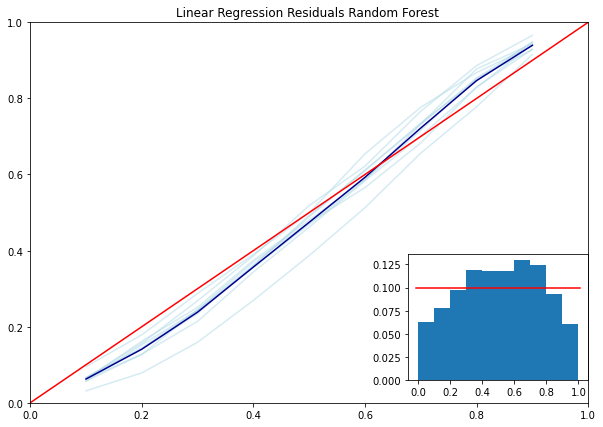

In [6]:
df["pred"]=df.apply(lambda row:row[2]["all"], axis=1)
df["target"]=df.apply(lambda row:row[2]["target"], axis=1)

method = "QRFL"

rels = []
sharps = []

for horizon in np.arange(1,10):
    pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].iloc[0]
    target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].iloc[0]
    
    rel, sharp = reliability_sharpness(pred,target)
    
    rels.append(rel)
    sharps.append(sharp)   
    

# Draw the average
quantiles = np.arange(1,10)/10.0
#Reliability Diagram
fig=plt.figure(figsize=(10,7))
plt.title("Linear Regression Residuals Random Forest ")
plt.gca().axes.set_xlim(0, 1)
plt.gca().axes.set_ylim(0, 1)
for rel in rels:
    plt.plot(quantiles,rel,alpha=0.5,color="lightblue")
plt.plot(quantiles,pd.DataFrame(rels).mean(),color="darkblue",alpha=1)
plt.plot([0,1],[0,1],c="red")

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.65, 0.17, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot([-0.01,1.01],[.1,.1],c="red")
ax2.bar(.05+np.arange(0,10)/10,pd.DataFrame(sharps).mean(),width=.1)


plt.show()

In [7]:
order_methods="""QRF
QRFL
QKNN
QKNNL
QGB
QGBL
QLR
MLP
NGBOOST
DT""".split("\n")

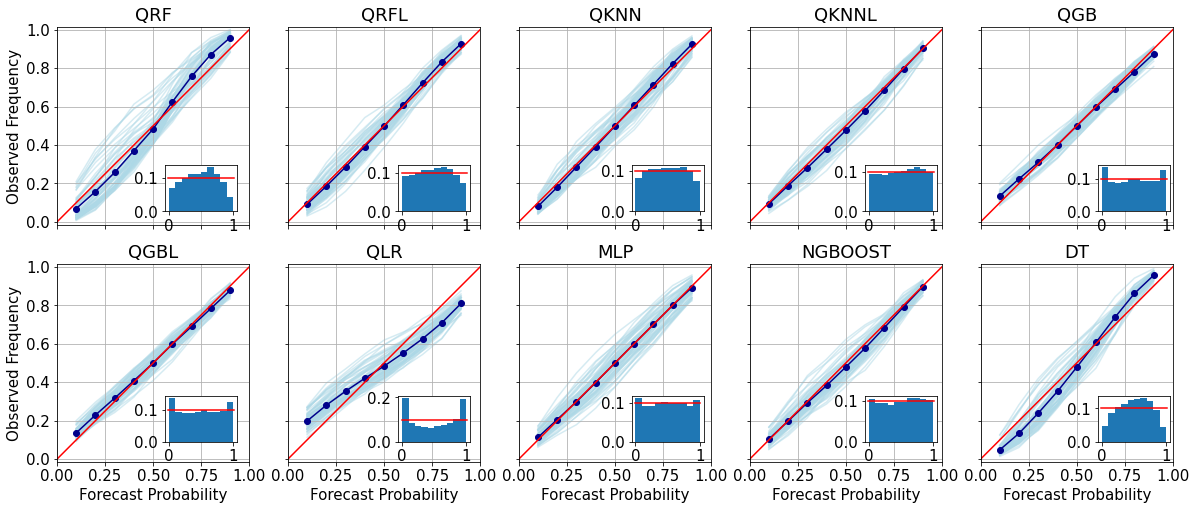

In [8]:
df["pred"]=df.apply(lambda row:row[2]["all"], axis=1)
df["target"]=df.apply(lambda row:row[2]["target"], axis=1)

plt.rcParams.update({'font.size': 15})

def draw(method,title,x,y,left,bottom):
    rels = []
    sharps = []

    for horizon in np.arange(1,60):
        pred = df[(df["horizon"]==horizon)&(df["method"]==method)]["pred"].iloc[0]
        target = df[(df["horizon"]==horizon)&(df["method"]==method)]["target"].iloc[0]

        rel, sharp = reliability_sharpness(pred,target)

        rels.append(rel)
        sharps.append(sharp)   


    # Draw the average
    quantiles = np.arange(1,10)/10
    #Reliability Diagram
    plt.title(title)
    plt.axis('equal')
    plt.gca().axes.set_xlim(0, 1)
    plt.gca().axes.set_ylim(0, 1)
    plt.gca().yaxis.grid(True)
    plt.gca().xaxis.grid(True)
    for rel in rels:
        plt.plot(quantiles,rel,alpha=0.5,color="lightblue",zorder=-1)
    plt.plot(quantiles,pd.DataFrame(rels).mean(),color="darkblue",alpha=1)
    plt.scatter(quantiles,pd.DataFrame(rels).mean(),color="darkblue",alpha=1,zorder=2)
    plt.plot([0,1],[0,1],c="red")
    if bottom:
        plt.xlabel("Forecast Probability")
    if left:
        plt.ylabel("Observed Frequency")
        
    plt.tick_params(labelleft=left, labelbottom=bottom,)
    
    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    left, bottom, width, height = [x, y, 0.05, 0.08]
    ax2 = fig.add_axes([left, bottom, width, height],label=f"ax{method}")

    ax2.plot([-0.01,1.01],[.1,.1],c="red")
    ax2.bar(.05+np.arange(0,10)/10,pd.DataFrame(sharps).mean(),width=.1)
    

fig=plt.figure(figsize=(20,8))

for i,label in enumerate(order_methods):
    plt.subplot(2,5,i+1)
    # Small chart pos
    xsc = 0.2+(i%5)*0.162
    ysc = 0.16+(1-int(i/5))*0.4
    left = False
    if i == 0 or i == 5:
        left=True
        
    bottom = False
    if i>4:
        bottom=True
    draw(label,label,xsc,ysc,left,bottom)

plt.savefig("reliability_sharpness.png")

In [9]:
from tqdm import tqdm as otqdm
otqdm.pandas()

In [13]:
from sklearn.metrics import classification_report, roc_curve, precision_score

def get_tp_fp_roc(row):
    pred = row["pred"]
    target = row["target"]
    ntarget = (np.array(target)>180).astype(int)
    
    # There are no peaks
    if sum(ntarget)==0:
        return pd.Series({
        "peaks":0,
        "tp":0,
        "fp":0,
        "roc":(0,0,0)
    })
    
    def get_perc(row):
        if (row.iloc[0]>180): return 1
        srow=row
        try:
            return 1-(srow[srow<180].index[-1])/100
        except:
            return 0
    pdf = pd.DataFrame(pred)
    pdf.columns = np.arange(1,100)
    pred_proba = pdf.apply(get_perc,axis=1)
    
    fpr, tpr, thresholds = roc_curve(ntarget,pred_proba)
    # We interpolate so all are the same
    x1_ref = np.linspace(0,1,100)
    ntpr = np.interp(x1_ref, fpr, tpr)
    
    tp = sum((pred_proba>.5).astype(int) * ntarget) 
    all_pred = sum( (pred_proba>.5).astype(int) )
    fp= all_pred-tp
    
    return pd.Series({
        "peaks":sum(ntarget),
        "tp":tp,
        "fp":fp,
        "roc":(x1_ref, ntpr)
    })

df_class = df.copy()
df_class[["peaks","tp","fp","roc"]]=df_class.progress_apply(get_tp_fp_roc,axis=1)


100%|██████████| 2791/2791 [01:54<00:00, 24.47it/s]


In [16]:
tpfp = df_class[df_class["peaks"]!=0].groupby("method").sum()
tpfp.loc[order_methods]

,horizon,3,peaks,tp,fp
method,,,,,
QRF,3046,100,740,0,0
QRFL,3046,100,740,10,5
QKNN,3046,100,740,0,0
QKNNL,3046,100,740,16,14
QGB,3046,100,740,75,29
QGBL,3046,100,740,94,37
QLR,3046,100,740,7,8
MLP,3046,100,740,87,123
NGBOOST,3046,100,740,9,1


100%|██████████| 10/10 [00:00<00:00, 273.42it/s]


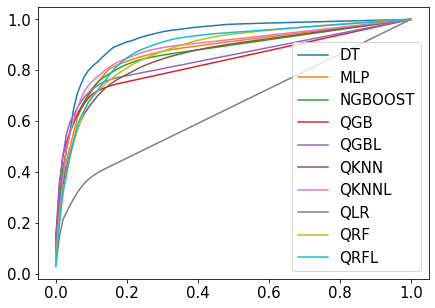

In [46]:
# Let's do the ROC Curve
def mean_curve(df):
    all_tprs = df.apply(lambda row: row["roc"][1],axis=1).values
    sum_tprs=np.zeros(len(all_tprs[0]))
    for single_tpr in all_tprs:
        sum_tprs+=single_tpr
    sum_tprs/=len(all_tprs)
    return pd.Series({
        "mtpr":sum_tprs
    })
mean_curve_df = df_class[df_class["peaks"]!=0].groupby("method").progress_apply(mean_curve)

plt.figure(figsize=(7,5))
for i,row in mean_curve_df.iterrows():
    plt.plot(np.linspace(0,1,100),row["mtpr"],label=i)
plt.legend()
plt.savefig("average_roc.png");